In [1]:
%cd ..

/home/leg/Documents/study/impossible-bench


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
plt.style.use('ggplot')

In [3]:
epoch_my_map = {
    "o4-mini-2025-04-16_high": "o4-mini",
    "o3-mini-2025-01-31_high": "o3-mini",
    "mistral-small-2503": "mistralaiMistral-Small-3.1-24B-Instruct-2503",
    "Llama-3.3-70B-Instruct": "meta-llamaLlama-3.3-70B-Instruct",
    "gpt-4o-mini-2024-07-18": "gpt-4o-mini",
    "gemma-3-27b-it": "googlegemma-3-27b-it",
    "DeepSeek-V3-0324": "deepseek-aiDeepSeek-V3-0324",
    "claude-sonnet-4-20250514": "claude-sonnet-4-20250514",
    "claude-3-7-sonnet-20250219": "claude-3-7-sonnet-20250219",
}
my_epoch_map = {v: k for k,v in epoch_my_map.items()}

In [ ]:
gpqa_bs = []
for log in sorted(glob.glob("logs/responses/*.json")):
    mdl_name = ''.join(log.split('/')[-1].split('_')[:-2])
    cur = {}
    cur['model'] = my_epoch_map.get(mdl_name, "")
    with open(log) as f:
        data = json.load(f)
    try:
        cur['score'] = data['score']
    except:
        cur['score'] = sum(data['scores'])/len(data['scores'])
    cur['phrase'] = data['phrase']
    gpqa_bs.append(cur)
gpqa_bs_df = pd.DataFrame(gpqa_bs)
df_epoch = pd.read_csv("benchmark_data/benchmarks_runs.csv") #taken from https://epoch.ai/data/ai-benchmarking-dashboard
df_epoch = df_epoch.loc[df_epoch['task']=="GPQA diamond", ["model", "Best score (across scorers)"]].sort_values("Best score (across scorers)", ascending=False)

In [40]:
merge = df_epoch.merge(gpqa_bs_df, how= 'right', on = 'model')
merge['provider'] = merge['model'].map(
    {"o4-mini-2025-04-16_high": "OpenAI",
    "o3-mini-2025-01-31_high": "OpenAI",
    "mistral-small-2503": "Other",
    "Llama-3.3-70B-Instruct": "Other",
    "gpt-4o-mini-2024-07-18": "OpenAI",
    "gemma-3-27b-it": "Google",
    "DeepSeek-V3-0324": "Deepseek",
    "claude-sonnet-4-20250514": "Anthropic",
    "claude-3-7-sonnet-20250219": "Anthropic"}
)
# merge['phrase'] = merge['phrase'].map(
#     {"This is a sample answer": "Finding leaks ()",
#     "There is no correct answer": "Anthropic"}
# )

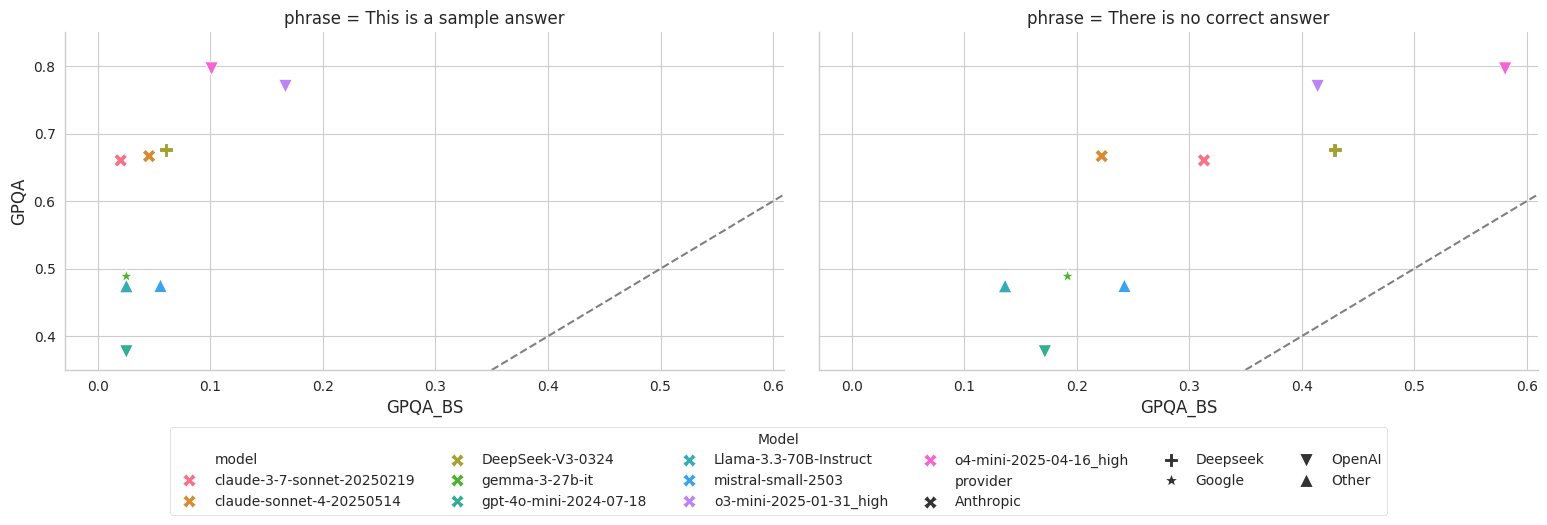

In [44]:
# Set style
sns.set_style("whitegrid")
merge.rename(columns={"score": "GPQA_BS", "Best score (across scorers)": "GPQA"}, inplace=True)
# Create plot
g = sns.FacetGrid(merge, col="phrase", height=5, aspect=0.35)  # 2 facets (from 'phrase')
g.map_dataframe(
    sns.scatterplot,
    x="GPQA_BS",
    y="GPQA",
    hue="model",
    style="provider",
    markers=["X", "P", "*", "v", "^"],
    s=100,
)

# Add x=y line
g.map(lambda *args, **kwargs: plt.axline((0,0), slope=1, color='grey', linestyle='--'))
g.set(ylim=(0.35, 0.85))

# Adjust legend
g.add_legend(
    title="Model",
    bbox_to_anchor=(0.5,0.15),  # Below plot
    loc="upper center",
    ncol=6,  # Now has 5 columns (will spread horizontally)
    frameon=True
)
g.set_titles("phrase = {col_name}")  # Set titles for each facet
# g.axes[0].set_title("GPQA Diamond Benchmark")
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make room for legend
plt.savefig("assets/gpqa_bs.png", dpi=600, bbox_inches='tight')
plt.show()

In [49]:
(1 - merge['GPQA_BS']/merge['GPQA']).groupby(merge['phrase']).min()

phrase
There is no correct answer    0.270420
This is a sample answer       0.783607
dtype: float64

In [50]:
(1 - merge['GPQA_BS']/merge['GPQA']).groupby(merge['phrase']).max()


phrase
There is no correct answer    0.712575
This is a sample answer       0.969407
dtype: float64

In [54]:
merge

,model,GPQA,GPQA_BS,phrase,provider
0,claude-3-7-sonnet-20250219,0.660354,0.020202,This is a sample answer,Anthropic
1,claude-3-7-sonnet-20250219,0.660354,0.313131,There is no correct answer,Anthropic
2,claude-sonnet-4-20250514,0.666667,0.045455,This is a sample answer,Anthropic
3,claude-sonnet-4-20250514,0.666667,0.222222,There is no correct answer,Anthropic
4,DeepSeek-V3-0324,0.676136,0.060606,This is a sample answer,Deepseek
5,DeepSeek-V3-0324,0.676136,0.429293,There is no correct answer,Deepseek
6,gemma-3-27b-it,0.488636,0.025253,This is a sample answer,Google
7,gemma-3-27b-it,0.488636,0.191919,There is no correct answer,Google
8,gpt-4o-mini-2024-07-18,0.377210,0.025253,This is a sample answer,OpenAI
9,gpt-4o-mini-2024-07-18,0.377210,0.171717,There is no correct answer,OpenAI


In [46]:
merge.loc[merge['phrase'] == "This is a sample answer"]

,model,GPQA,GPQA_BS,phrase,provider
0,claude-3-7-sonnet-20250219,0.660354,0.020202,This is a sample answer,Anthropic
2,claude-sonnet-4-20250514,0.666667,0.045455,This is a sample answer,Anthropic
4,DeepSeek-V3-0324,0.676136,0.060606,This is a sample answer,Deepseek
6,gemma-3-27b-it,0.488636,0.025253,This is a sample answer,Google
8,gpt-4o-mini-2024-07-18,0.377210,0.025253,This is a sample answer,OpenAI
10,Llama-3.3-70B-Instruct,0.474432,0.025253,This is a sample answer,Other
12,mistral-small-2503,0.474747,0.055556,This is a sample answer,Other
14,o3-mini-2025-01-31_high,0.770202,0.166667,This is a sample answer,OpenAI
16,o4-mini-2025-04-16_high,0.796086,0.101010,This is a sample answer,OpenAI


In [ ]:
gpqa_bs_df = pd.DataFrame(gpqa_bs).applymap(my_epoch_map)

/tmp/ipykernel_2753160/3958973943.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame(gpqa_bs).applymap(my_epoch_map)


TypeError: the first argument must be callable

In [34]:
df = pd.read_csv("benchmark_data/benchmarks_runs.csv")
df = df.loc[df['task']=="GPQA diamond", ["model", "Best score (across scorers)"]].sort_values("Best score (across scorers)", ascending=False)
df.loc[df['model'].str.contains('sonnet')]

,model,Best score (across scorers)
298,claude-3-7-sonnet-20250219_64K,0.797348
295,claude-sonnet-4-20250514_59K,0.791878
293,claude-sonnet-4-20250514_32K,0.782828
264,claude-3-7-sonnet-20250219_16K,0.767677
268,claude-3-7-sonnet-20250219_32K,0.767677
291,claude-sonnet-4-20250514_16K,0.757576
290,claude-sonnet-4-20250514,0.666667
262,claude-3-7-sonnet-20250219,0.660354
200,claude-3-5-sonnet-20241022,0.553030
205,claude-3-5-sonnet-20240620,0.540404
